In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Cargar el archivo CSV
df = pd.read_csv('Integracion_con_patógenos_y_enfermedades_Propionibacterium_F_Padj_menor_0.05.csv')
# Mostrar las primeras filas y la informaci\u00f3n del DataFrame
df.head()


,Genes,DisGeNET_Term,DisGeNET_Pvalue_Adjusted,GeDiPNet_Term,GeDiPNet_Pvalue_Adjusted,Orphanet_Term,Orphanet_Pvalue_Adjusted,Virus_Host_Term,Virus_Host_Pvalue_Adjusted,Host organism(s)_Intact,Confidence value(s)_Intact,Taxid interactor A_Intact,Taxid interactor B_Intact
0,AATK,NaN,NaN,NaN,NaN,Hereditary sensory and autonomic neuropathy du...,0.0155394890951578; 0.0184072076199886,NaN,NaN,NaN,NaN,NaN,NaN
1,ABCA7,NaN,NaN,NaN,NaN,Autosomal dominant centronuclear myopathy ORPH...,0.0036432528126817; 0.0081550609410495; 0.0155...,NaN,NaN,NaN,NaN,NaN,NaN
2,ACAP3,NaN,NaN,NaN,NaN,Otospondylomegaepiphyseal dysplasia ORPHA:1427...,0.0144185025972157; 0.0155394890951578; 0.0155...,NaN,NaN,NaN,NaN,NaN,NaN
3,ACOT7,NaN,NaN,NaN,NaN,PRKAR1B-related neurodegenerative dementia wit...,0.0155394890951578,NaN,NaN,NaN,NaN,NaN,NaN
4,ADAM8,NaN,NaN,NaN,NaN,Idiopathic CD4 lymphocytopenia ORPHA:228000; P...,0.0155394890951578; 0.0155394890951578; 0.0155...,NaN,NaN,NaN,NaN,NaN,NaN


    Gene DisGeNET_Term_categories GeDiPNet_Term_categories  \
0   AATK          Sin información          Sin información   
1  ABCA7          Sin información          Sin información   
2  ACAP3          Sin información          Sin información   
3  ACOT7          Sin información          Sin información   
4  ADAM8          Sin información          Sin información   

                            Orphanet_Term_categories  
0                                 Otras Enfermedades  
1  Otras Enfermedades, Enfermedades Infecciosas, ...  
2      Otras Enfermedades, Enfermedades Neurológicas  
3                                 Otras Enfermedades  
4       Otras Enfermedades, Enfermedades Infecciosas  
Gráfico guardado como 'disease_categories_barplot.png'


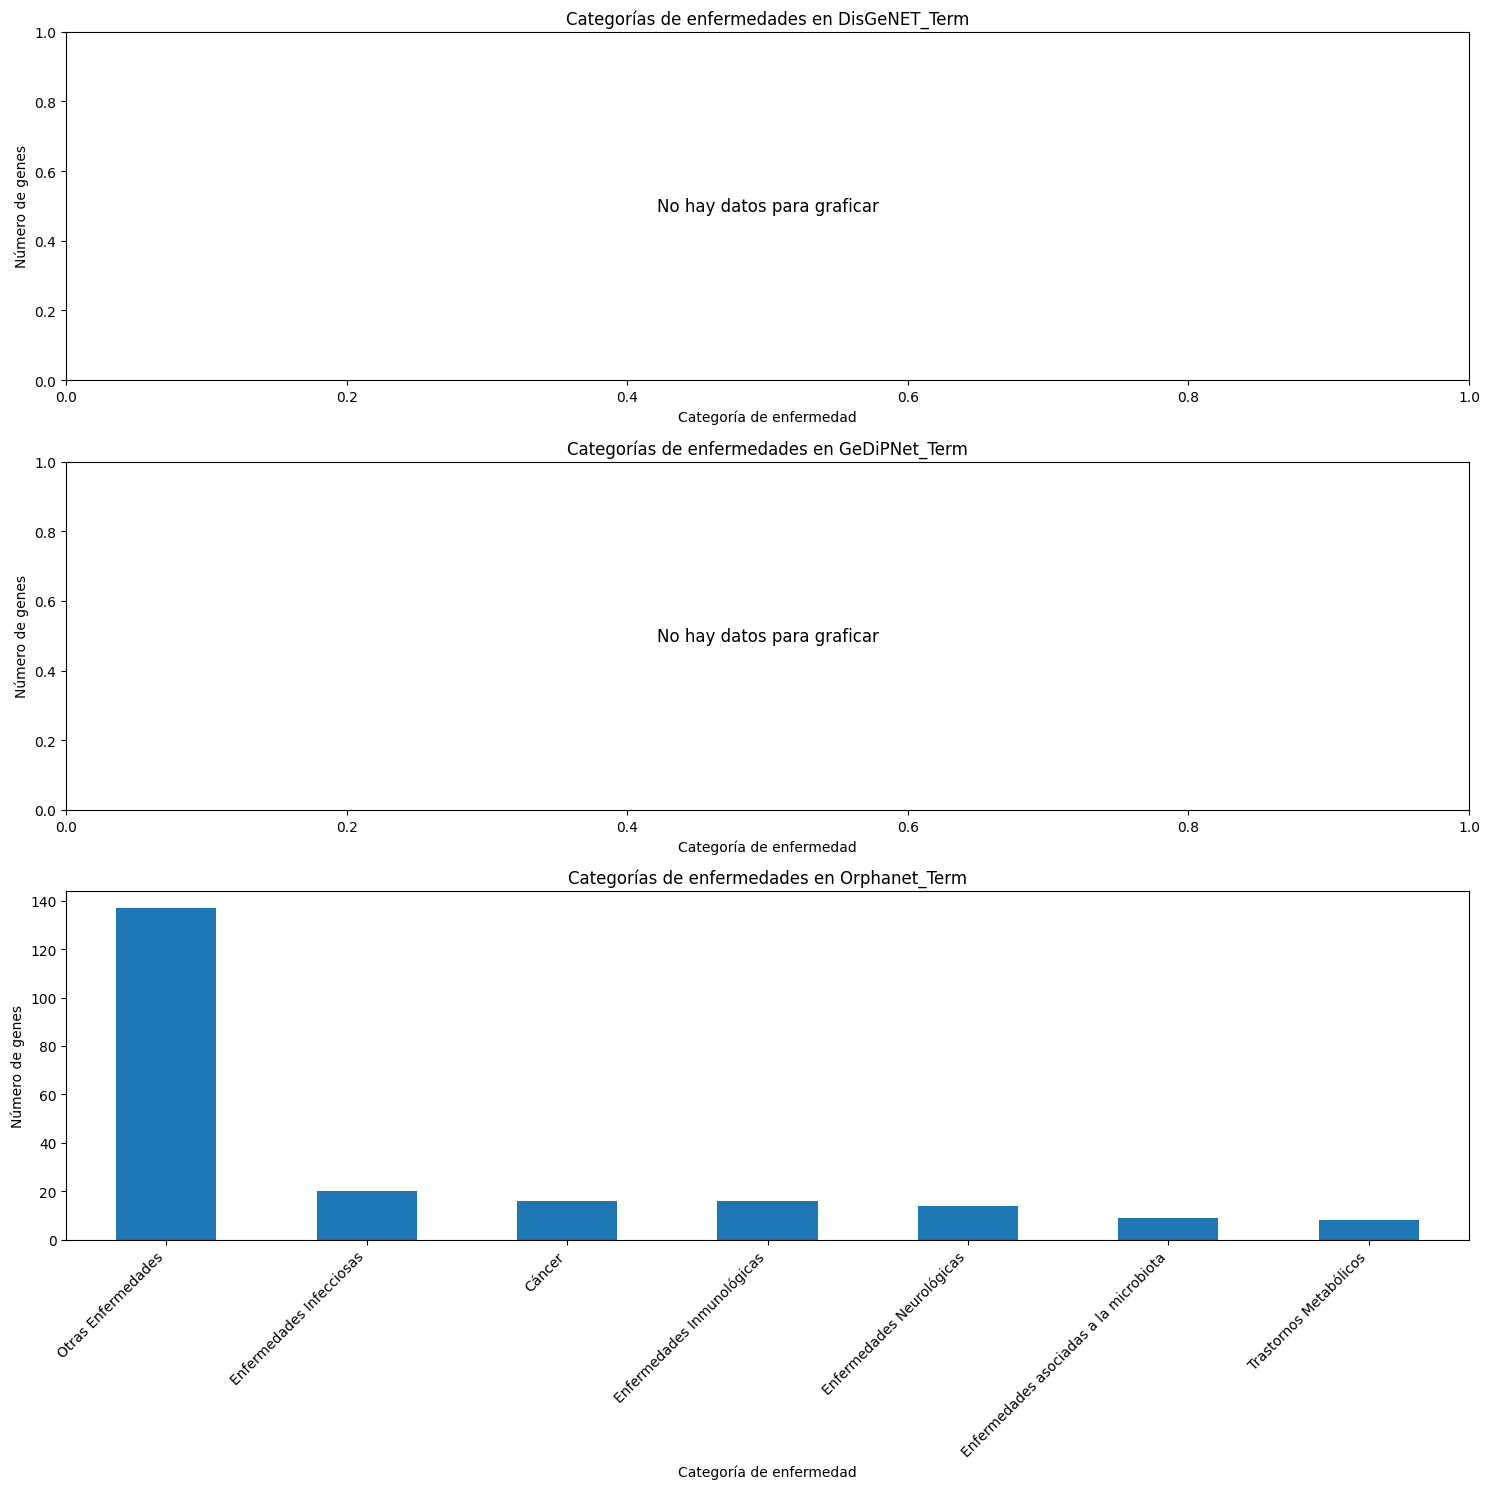

In [11]:


# Definir categorías de enfermedades
categories = {
    "Cáncer": ["carcinoma", "cancer", "tumor", "neoplasm", "leukemia", "lymphoma", "sarcoma", "melanoma"],
    "Enfermedades Infecciosas": ["infection", "viral", "bacterial", "fungal", "parasitic", "malaria", "HIV", "bacteria", "tuberculosis"],
    "Enfermedades Inmunológicas": ["autoimmune", "lupus", "rheumatoid", "asthma", "allergy", "immunodeficiency"],
    "Enfermedades Neurológicas": ["neurological", "amyotrophic", "parkinson", "alzheimer", "epilepsy", "schizophrenia", "bipolar disorder", "autism"],
    "Enfermedades Cardiovasculares": ["cardiovascular", "heart", "hypertension", "myocardial", "stroke", "angina"],
    "Enfermedades Renales": ["kidney failure", "nephropathy", "glomerulonephritis", "nephrotic syndrome"],
    "Trastornos Metabólicos": ["amyloidosis", "glycogen storage disease", "citrullinemia"],
    "Trastornos Genéticos": ["Ehlers-Danlos syndrome", "Charcot-Marie-Tooth disease", "epidermolysis bullosa"],
    "Trastornos de la Piel": ["dermatitis", "ichthyosis", "erythrokeratodermia"],
    "Enfermedades asociadas a la microbiota": [
        "dysbiosis", "gut microbiota", "intestinal microbiota", "helicobacter pylori", "necrotizing enterocolitis", 
        "inflammatory bowel disease", "celiac disease", "acute diarrhea", "non-alcoholic fatty liver disease", 
        "irritable bowel syndrome", "obesity", "diabetes", "inflammatory intestinal disease", 
        "stress", "anxiety", "digestive system", "poor diet", "fiber deficiency", 
        "sedentarism", "alcohol", "tobacco", "diarrhea", "cramps", "constipation"
    ],
    "Otras Enfermedades": []  # Aquí se incluirán enfermedades no clasificadas anteriormente
}

def classify_disease(disease):
    # Verificar si la enfermedad es NaN o si es "Sin información"
    if pd.isna(disease) or disease.lower() == "sin información":
        return "Sin información"
    
    # Convertir a minúsculas para una comparación insensible a mayúsculas/minúsculas
    disease = disease.lower()
    
    # Buscar coincidencias en las categorías definidas
    for category, keywords in categories.items():
        if any(keyword in disease for keyword in keywords):
            return category
            
    # Si no se encontró coincidencia, retornar "Otras Enfermedades"
    return "Otras Enfermedades"

def process_disease_column(column):
    if pd.isna(column):
        return ["Sin información"]
    diseases = column.split(';')
    return [disease.strip() for disease in diseases]

# Procesar columnas de enfermedades
disease_columns = ['DisGeNET_Term', 'GeDiPNet_Term', 'Orphanet_Term']

for col in disease_columns:
    df[f'{col}_processed'] = df[col].apply(process_disease_column)
    df[f'{col}_categories'] = df[f'{col}_processed'].apply(lambda x: [classify_disease(disease) for disease in x])

# Crear un nuevo DataFrame con el mapeo
gene_disease_mapping = pd.DataFrame()
gene_disease_mapping['Gene'] = df['Genes']

for col in disease_columns:
    gene_disease_mapping[f'{col}_categories'] = df[f'{col}_categories'].apply(lambda x: ', '.join(set(x)))

# Mostrar las primeras filas del nuevo DataFrame
print(gene_disease_mapping.head())

# Contar las categorías de enfermedades para cada fuente, excluyendo "Sin información"
category_counts = {}
for col in disease_columns:
    # Excluir "Sin información"
    filtered_categories = gene_disease_mapping[f'{col}_categories'].apply(
        lambda x: ', '.join([cat for cat in x.split(', ') if cat != 'Sin información'])
    )
    # Contar las categorías
    category_counts[col] = filtered_categories.str.get_dummies(sep=', ').sum().sort_values(ascending=False)

# Crear un gráfico de barras para cada fuente de enfermedades
fig, axes = plt.subplots(len(disease_columns), 1, figsize=(15, 5 * len(disease_columns)))

for i, (source, counts) in enumerate(category_counts.items()):
    ax = axes[i]
    if counts.empty:
        ax.text(0.5, 0.5, 'No hay datos para graficar', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(f'Categorías de enfermedades en {source}')
        ax.set_xlabel('Categoría de enfermedad')
        ax.set_ylabel('Número de genes')
    else:
        counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Categorías de enfermedades en {source}')
        ax.set_xlabel('Categoría de enfermedad')
        ax.set_ylabel('Número de genes')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('disease_categories_barplot.png')
print("Gráfico guardado como 'disease_categories_barplot.png'")




Heatmap guardado como 'protein_interaction_heatmap.png'


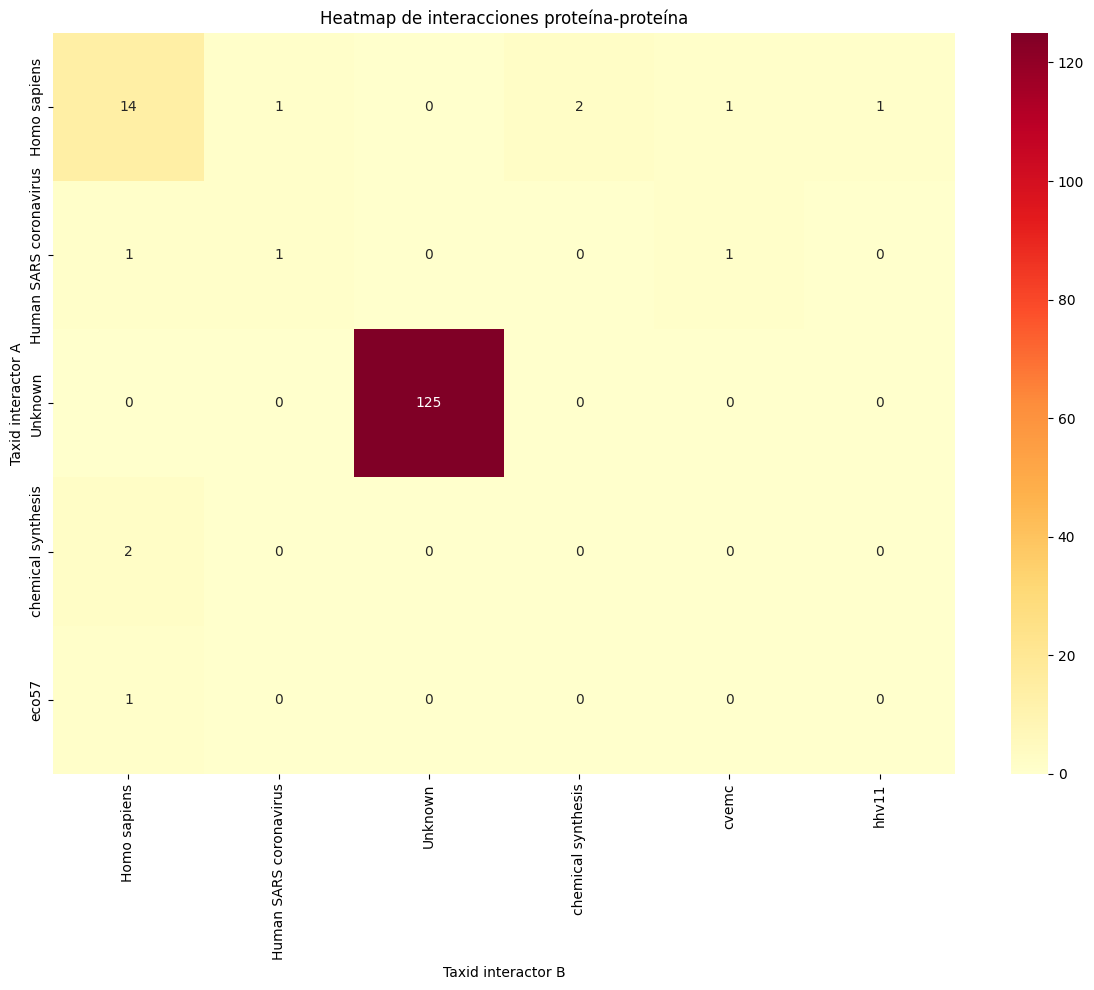

In [12]:
# Función para procesar los campos de taxa que pueden tener múltiples valores separados por ';'
def process_taxid_column(column):
    taxa = column.split(';')
    return [taxon.strip() for taxon in taxa]

# Procesar las columnas de interacciones para manejar múltiples taxones
interaction_df = df[['Genes', 'Taxid interactor A_Intact', 'Taxid interactor B_Intact']].copy()

# Rellenar valores nulos con 'Unknown' y separar los taxones
interaction_df['Taxid interactor A_Intact'] = interaction_df['Taxid interactor A_Intact'].fillna('Unknown').apply(process_taxid_column)
interaction_df['Taxid interactor B_Intact'] = interaction_df['Taxid interactor B_Intact'].fillna('Unknown').apply(process_taxid_column)

# Expandir el DataFrame para tener una fila por cada combinación de taxa en interactor A e interactor B
interaction_df = interaction_df.explode('Taxid interactor A_Intact').explode('Taxid interactor B_Intact')

# Crear la matriz de interacciones
interaction_matrix = pd.crosstab(interaction_df['Taxid interactor A_Intact'], interaction_df['Taxid interactor B_Intact'])

# Generar el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(interaction_matrix, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Heatmap de interacciones proteína-proteína')
plt.xlabel('Taxid interactor B')
plt.ylabel('Taxid interactor A')
plt.tight_layout()
plt.savefig('protein_interaction_heatmap.png')
print("Heatmap guardado como 'protein_interaction_heatmap.png'")



Contenido de confidence_matrix:
Taxid interactor B_Intact Homo sapiens Human SARS coronavirus Unknown  \
Taxid interactor A_Intact                                               
Homo sapiens                      0.61                   0.58     NaN   
Human SARS coronavirus            0.58                   0.58     NaN   
Unknown                            NaN                    NaN     0.0   
chemical synthesis               0.585                    NaN     NaN   
eco57                         0.633333                    NaN     NaN   

Taxid interactor B_Intact chemical synthesis cvemc hhv11  
Taxid interactor A_Intact                                 
Homo sapiens                           0.515  0.58  0.62  
Human SARS coronavirus                   NaN  0.58   NaN  
Unknown                                  NaN   NaN   NaN  
chemical synthesis                       NaN   NaN   NaN  
eco57                                    NaN   NaN   NaN  


C:\Users\3060\AppData\Local\Temp\ipykernel_24444\3180631734.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  confidence_matrix = confidence_matrix.fillna(0)


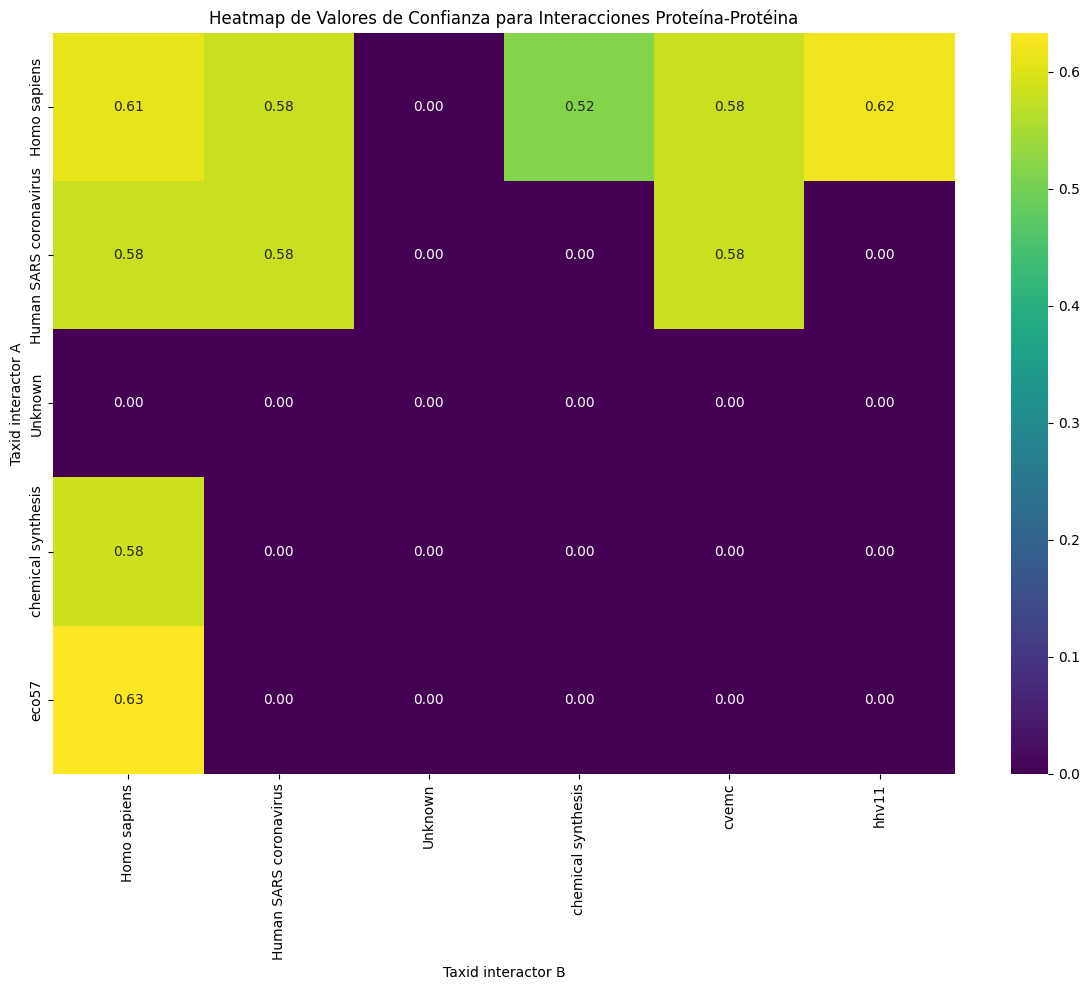

In [13]:


# Función para procesar columnas que contienen listas separadas por ";"
def process_column(column):
    if isinstance(column, str):
        return [item.strip() for item in column.split(';')]
    return []

# Función para procesar las columnas de confianza
def process_confidence_column(column):
    if isinstance(column, str):
        return [float(conf) for conf in process_column(column)]
    return []

# Procesar las columnas de interacciones para manejar múltiples taxones
interaction_df = df[['Genes', 'Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact', 'Host organism(s)_Intact']].copy()

# Procesar las columnas de interacciones para manejar múltiples valores
interaction_df['Taxid interactor A_Intact'] = interaction_df['Taxid interactor A_Intact'].fillna('Unknown').apply(process_column)
interaction_df['Taxid interactor B_Intact'] = interaction_df['Taxid interactor B_Intact'].fillna('Unknown').apply(process_column)
interaction_df['Confidence value(s)_Intact'] = interaction_df['Confidence value(s)_Intact'].fillna('0').apply(process_confidence_column)

# Expandir el DataFrame para tener una fila por cada combinación de taxones y valores de confianza
interaction_df = interaction_df.explode('Taxid interactor A_Intact')
interaction_df = interaction_df.explode('Taxid interactor B_Intact')
interaction_df = interaction_df.explode('Confidence value(s)_Intact')

# Asegurarse de que las columnas no contengan listas
interaction_df['Taxid interactor A_Intact'] = interaction_df['Taxid interactor A_Intact'].astype(str)
interaction_df['Taxid interactor B_Intact'] = interaction_df['Taxid interactor B_Intact'].astype(str)

# Crear la matriz de confianza entre Taxid interactor A y Taxid interactor B
confidence_matrix = pd.pivot_table(interaction_df, values='Confidence value(s)_Intact', index='Taxid interactor A_Intact', columns='Taxid interactor B_Intact', aggfunc='mean')

# Verificar el contenido de la matriz de confianza
print("Contenido de confidence_matrix:")
print(confidence_matrix)

# Manejar valores NaN en la matriz de confianza
confidence_matrix = confidence_matrix.fillna(0)

# Generar el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(confidence_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap de Valores de Confianza para Interacciones Proteína-Protéina')
plt.xlabel('Taxid interactor B')
plt.ylabel('Taxid interactor A')
plt.tight_layout()
plt.savefig('protein_interaction_confidence_heatmap.png')
plt.show()  # Mostrar el gráfico en lugar de solo guardarlo





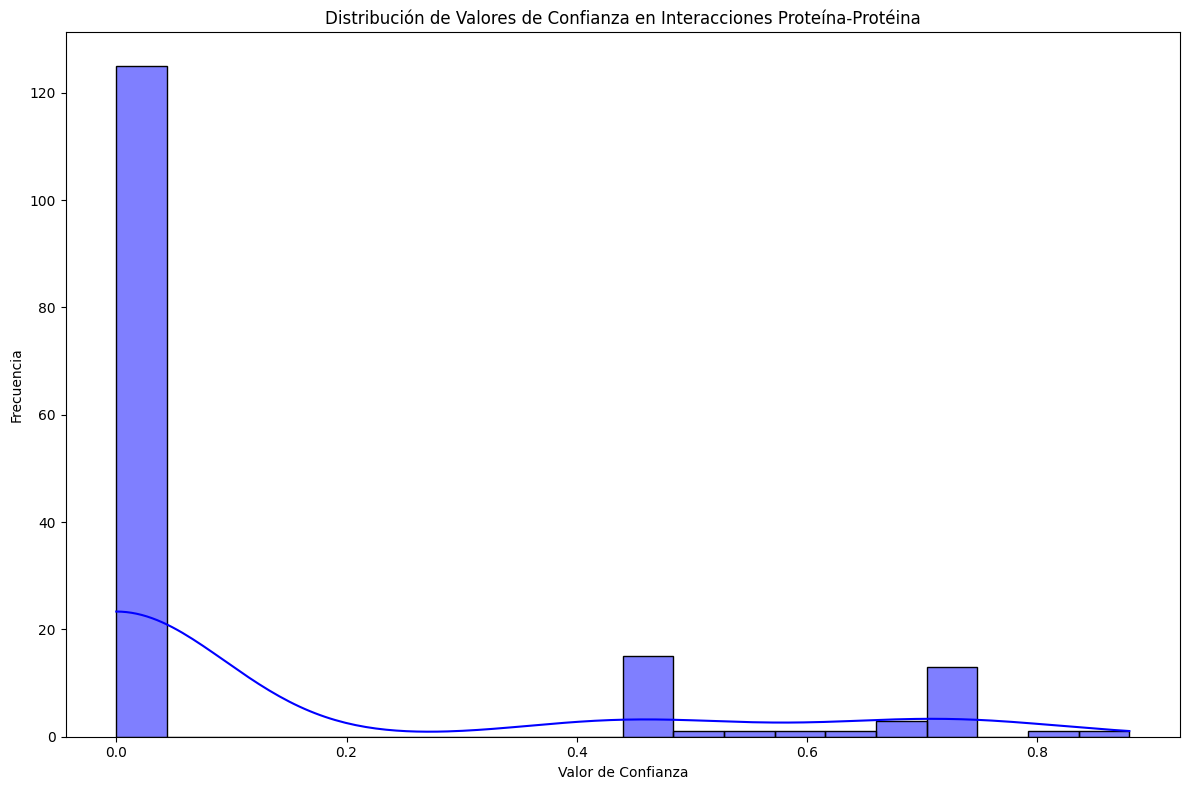

In [14]:
# Asumiendo que 'interaction_df' ya está procesado
plt.figure(figsize=(12, 8))

# Crear un gráfico de barras para la distribución de valores de confianza
sns.histplot(interaction_df['Confidence value(s)_Intact'], bins=20, kde=True, color='b')
plt.title('Distribución de Valores de Confianza en Interacciones Proteína-Protéina')
plt.xlabel('Valor de Confianza')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.savefig('confidence_distribution_bar_plot.png')
plt.show()

Taxid interactor A_Intact      object
Taxid interactor B_Intact      object
Confidence value(s)_Intact    float64
dtype: object
(162, 3)


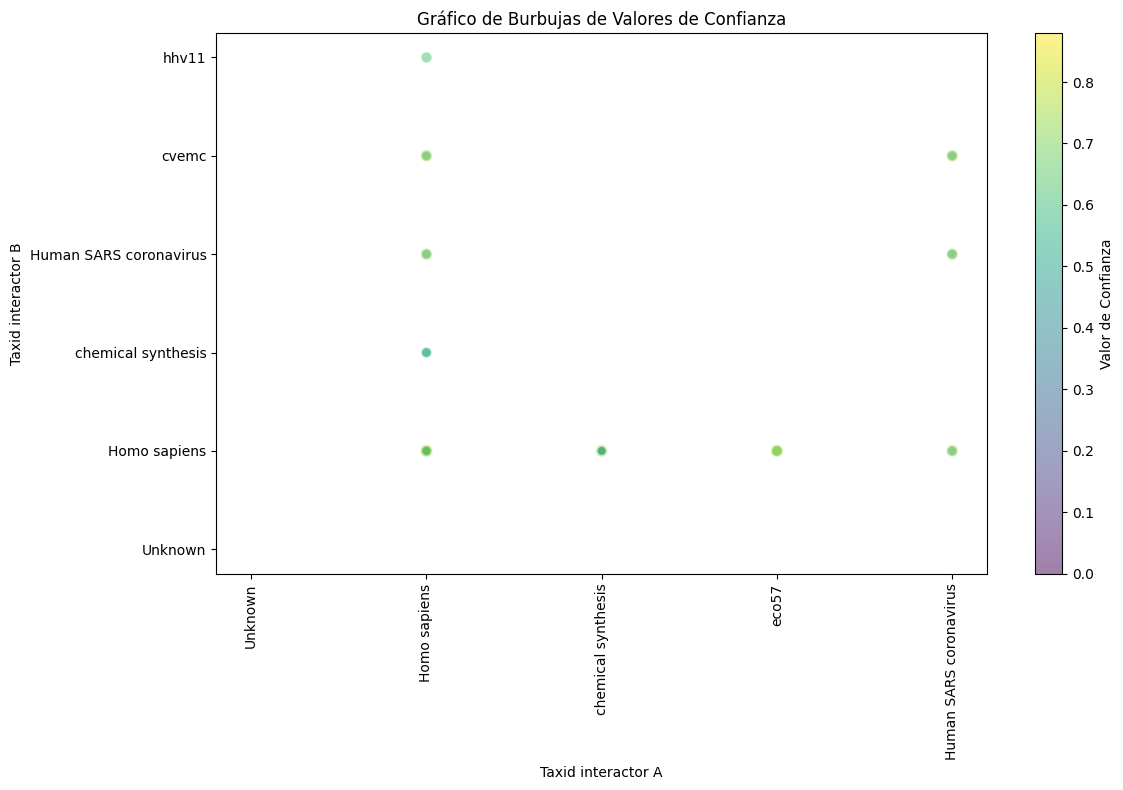

In [15]:
# Convertir la columna 'Confidence value(s)_Intact' a tipo numérico
interaction_df['Confidence value(s)_Intact'] = pd.to_numeric(interaction_df['Confidence value(s)_Intact'], errors='coerce')

# Eliminar filas con valores nulos en 'Confidence value(s)_Intact'
interaction_df = interaction_df.dropna(subset=['Confidence value(s)_Intact'])

# Verificar los tamaños y tipos después de la conversión
print(interaction_df[['Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact']].dtypes)
print(interaction_df[['Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact']].shape)

# Crear el gráfico de burbujas
plt.figure(figsize=(12, 8))

plt.scatter(
    interaction_df['Taxid interactor A_Intact'],
    interaction_df['Taxid interactor B_Intact'],
    s=interaction_df['Confidence value(s)_Intact'] * 100,  # Tamaño de la burbuja
    alpha=0.5,
    c=interaction_df['Confidence value(s)_Intact'],  # Color según el valor de confianza
    cmap='viridis',  # Mapa de colores
    edgecolors='w'
)

plt.title('Gráfico de Burbujas de Valores de Confianza')
plt.xlabel('Taxid interactor A')
plt.ylabel('Taxid interactor B')
plt.colorbar(label='Valor de Confianza')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('confidence_bubble_chart.png')
plt.show()

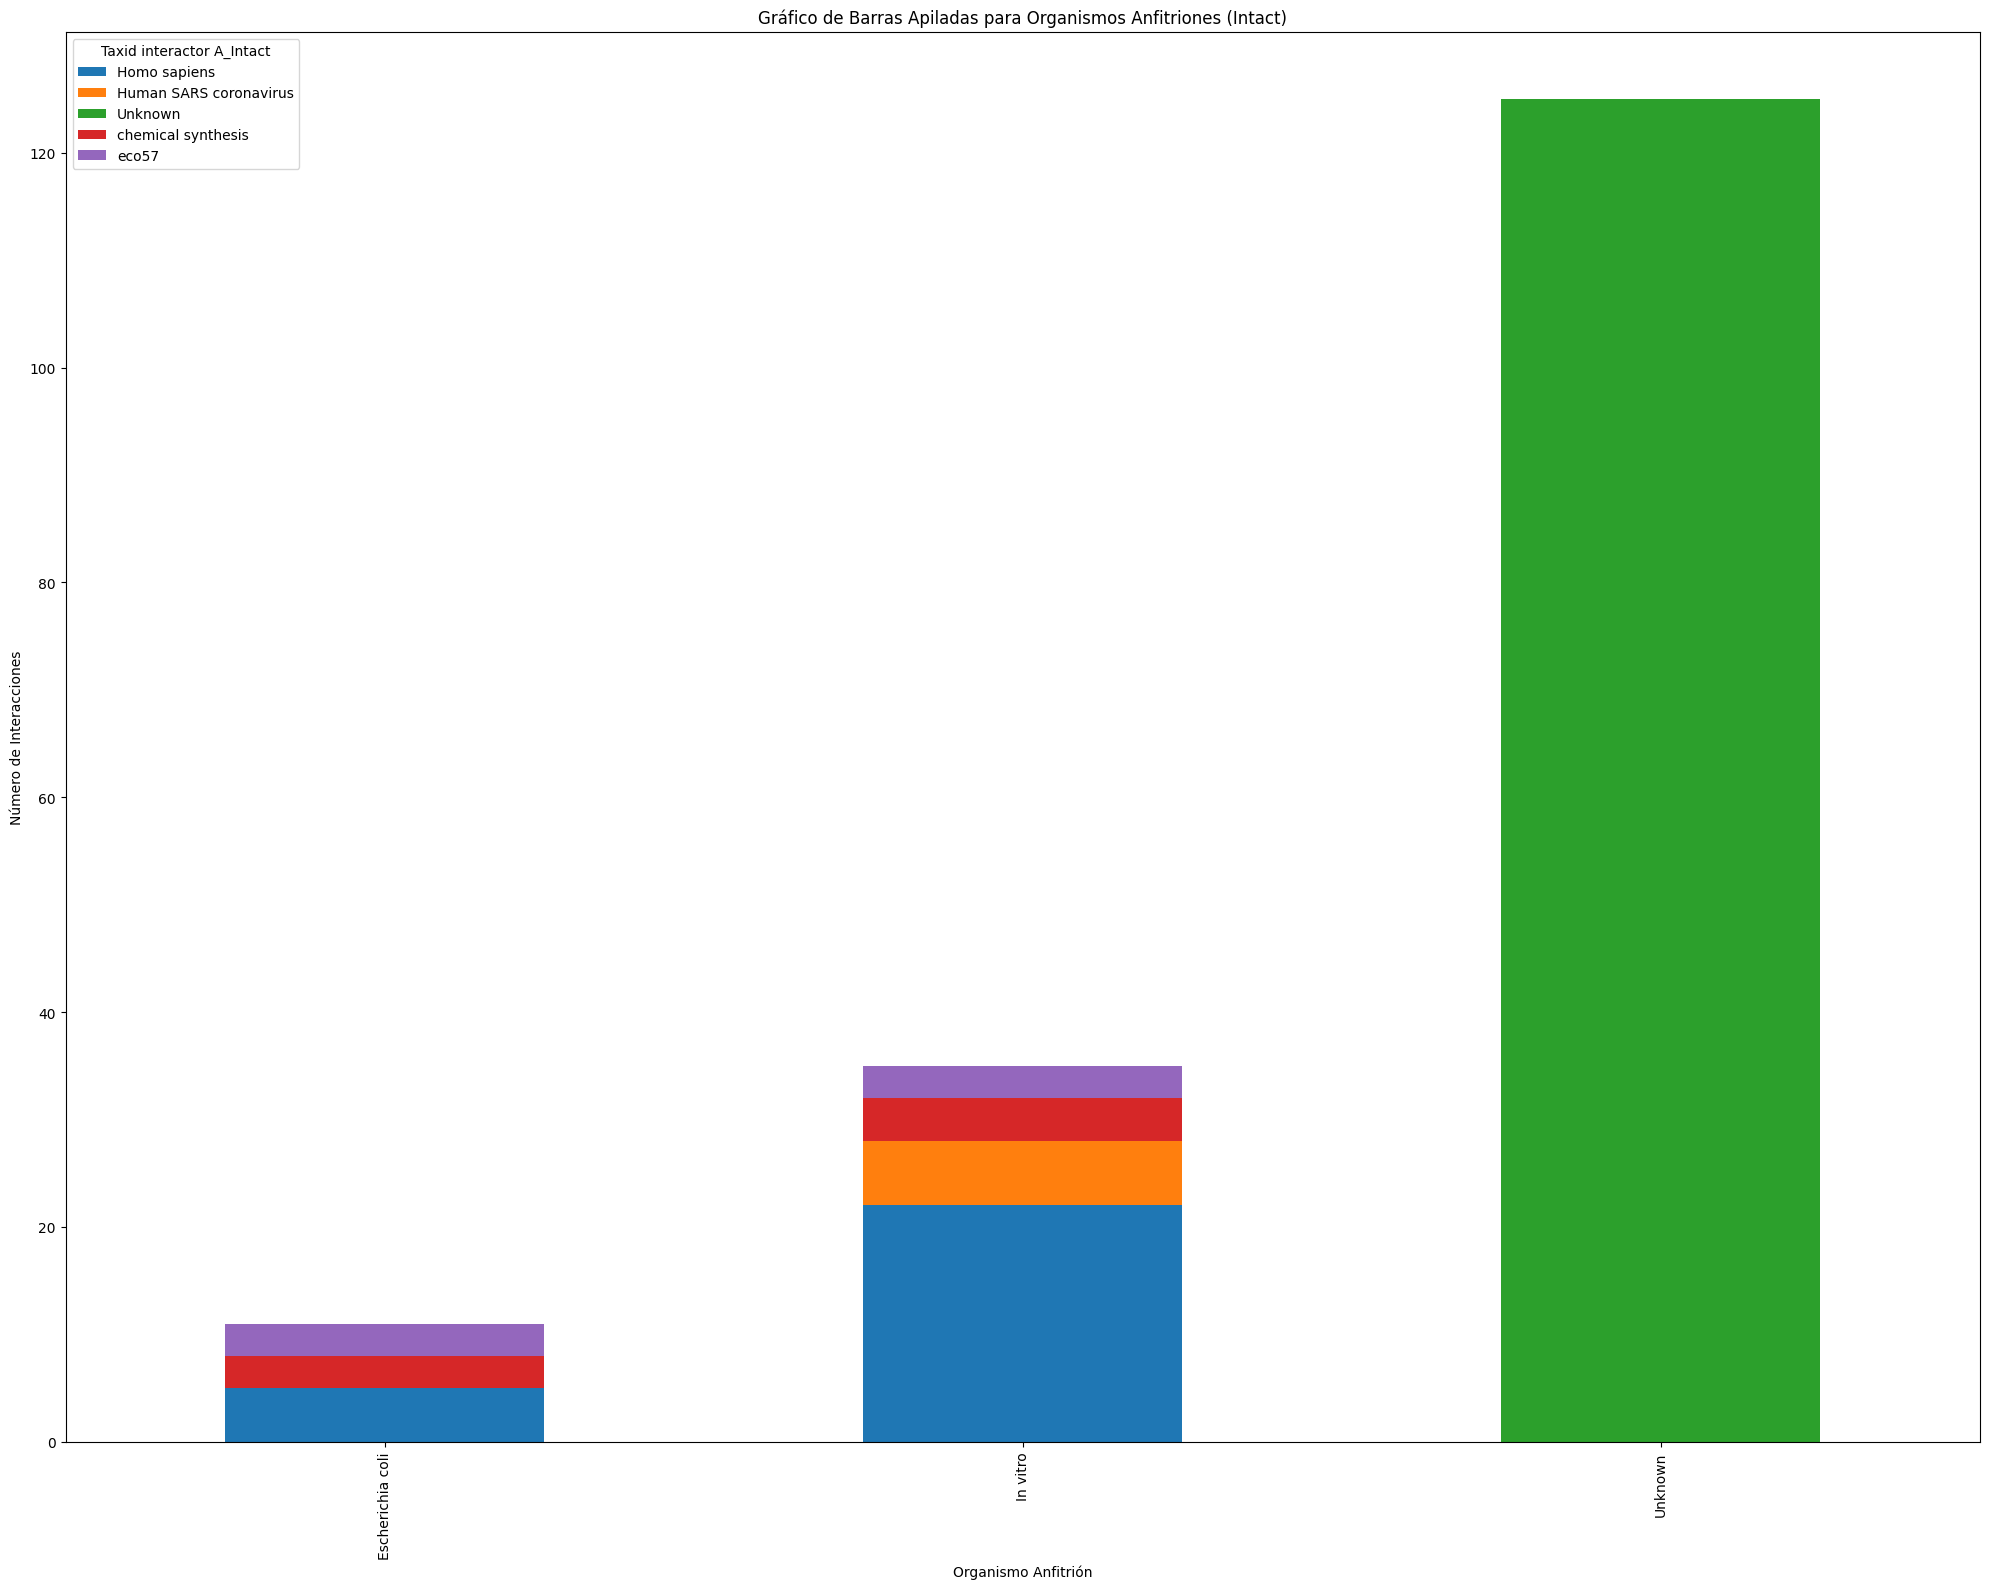

In [16]:
# Supongamos que tienes una columna 'Host organism(s)_Intact' en 'interaction_df'
interaction_df['Host organism(s)_Intact'] = interaction_df['Host organism(s)_Intact'].fillna('Unknown').apply(process_column)

# Expandir los organismos anfitriones
interaction_df = interaction_df.explode('Host organism(s)_Intact')

# Crear una tabla de datos para el gráfico apilado
host_data = interaction_df.groupby(['Host organism(s)_Intact', 'Taxid interactor A_Intact']).size().unstack(fill_value=0)

# Generar el gráfico de barras apiladas
host_data.plot(kind='bar', stacked=True, figsize=(20, 16))
plt.title('Gráfico de Barras Apiladas para Organismos Anfitriones (Intact)')
plt.xlabel('Organismo Anfitrión')
plt.ylabel('Número de Interacciones')
plt.tight_layout()
plt.savefig('stacked_bar_plot_host_organisms.png')
plt.show()

<Figure size 2400x2200 with 0 Axes>

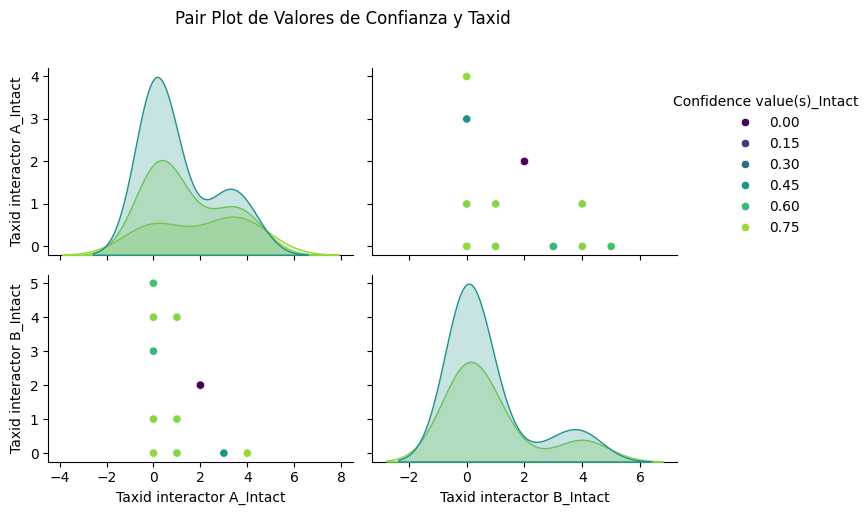

In [17]:
# Crear un DataFrame con valores numéricos para Pair Plot
pair_plot_df = interaction_df[['Taxid interactor A_Intact', 'Taxid interactor B_Intact', 'Confidence value(s)_Intact']].copy()

# Convertir los taxones a categorías para el pairplot
pair_plot_df['Taxid interactor A_Intact'] = pair_plot_df['Taxid interactor A_Intact'].astype('category').cat.codes
pair_plot_df['Taxid interactor B_Intact'] = pair_plot_df['Taxid interactor B_Intact'].astype('category').cat.codes

# Ajustar el tamaño de la figura
plt.figure(figsize=(24, 22))  # Ajusta el tamaño según tus necesidades

# Generar el Pair Plot
pair_plot = sns.pairplot(pair_plot_df, hue='Confidence value(s)_Intact', palette='viridis')

# Añadir título
pair_plot.fig.suptitle('Pair Plot de Valores de Confianza y Taxid', y=1.02)

# Ajustar la posición de la leyenda
pair_plot._legend.set_bbox_to_anchor((1.25, 0.7))  # Ajusta la posición (x, y) según sea necesario

# Ajustar el layout
plt.tight_layout()
plt.savefig('pair_plot_confidence_taxid.png')
plt.show()

Heatmap guardado como 'gene_virus_host_heatmap.png'


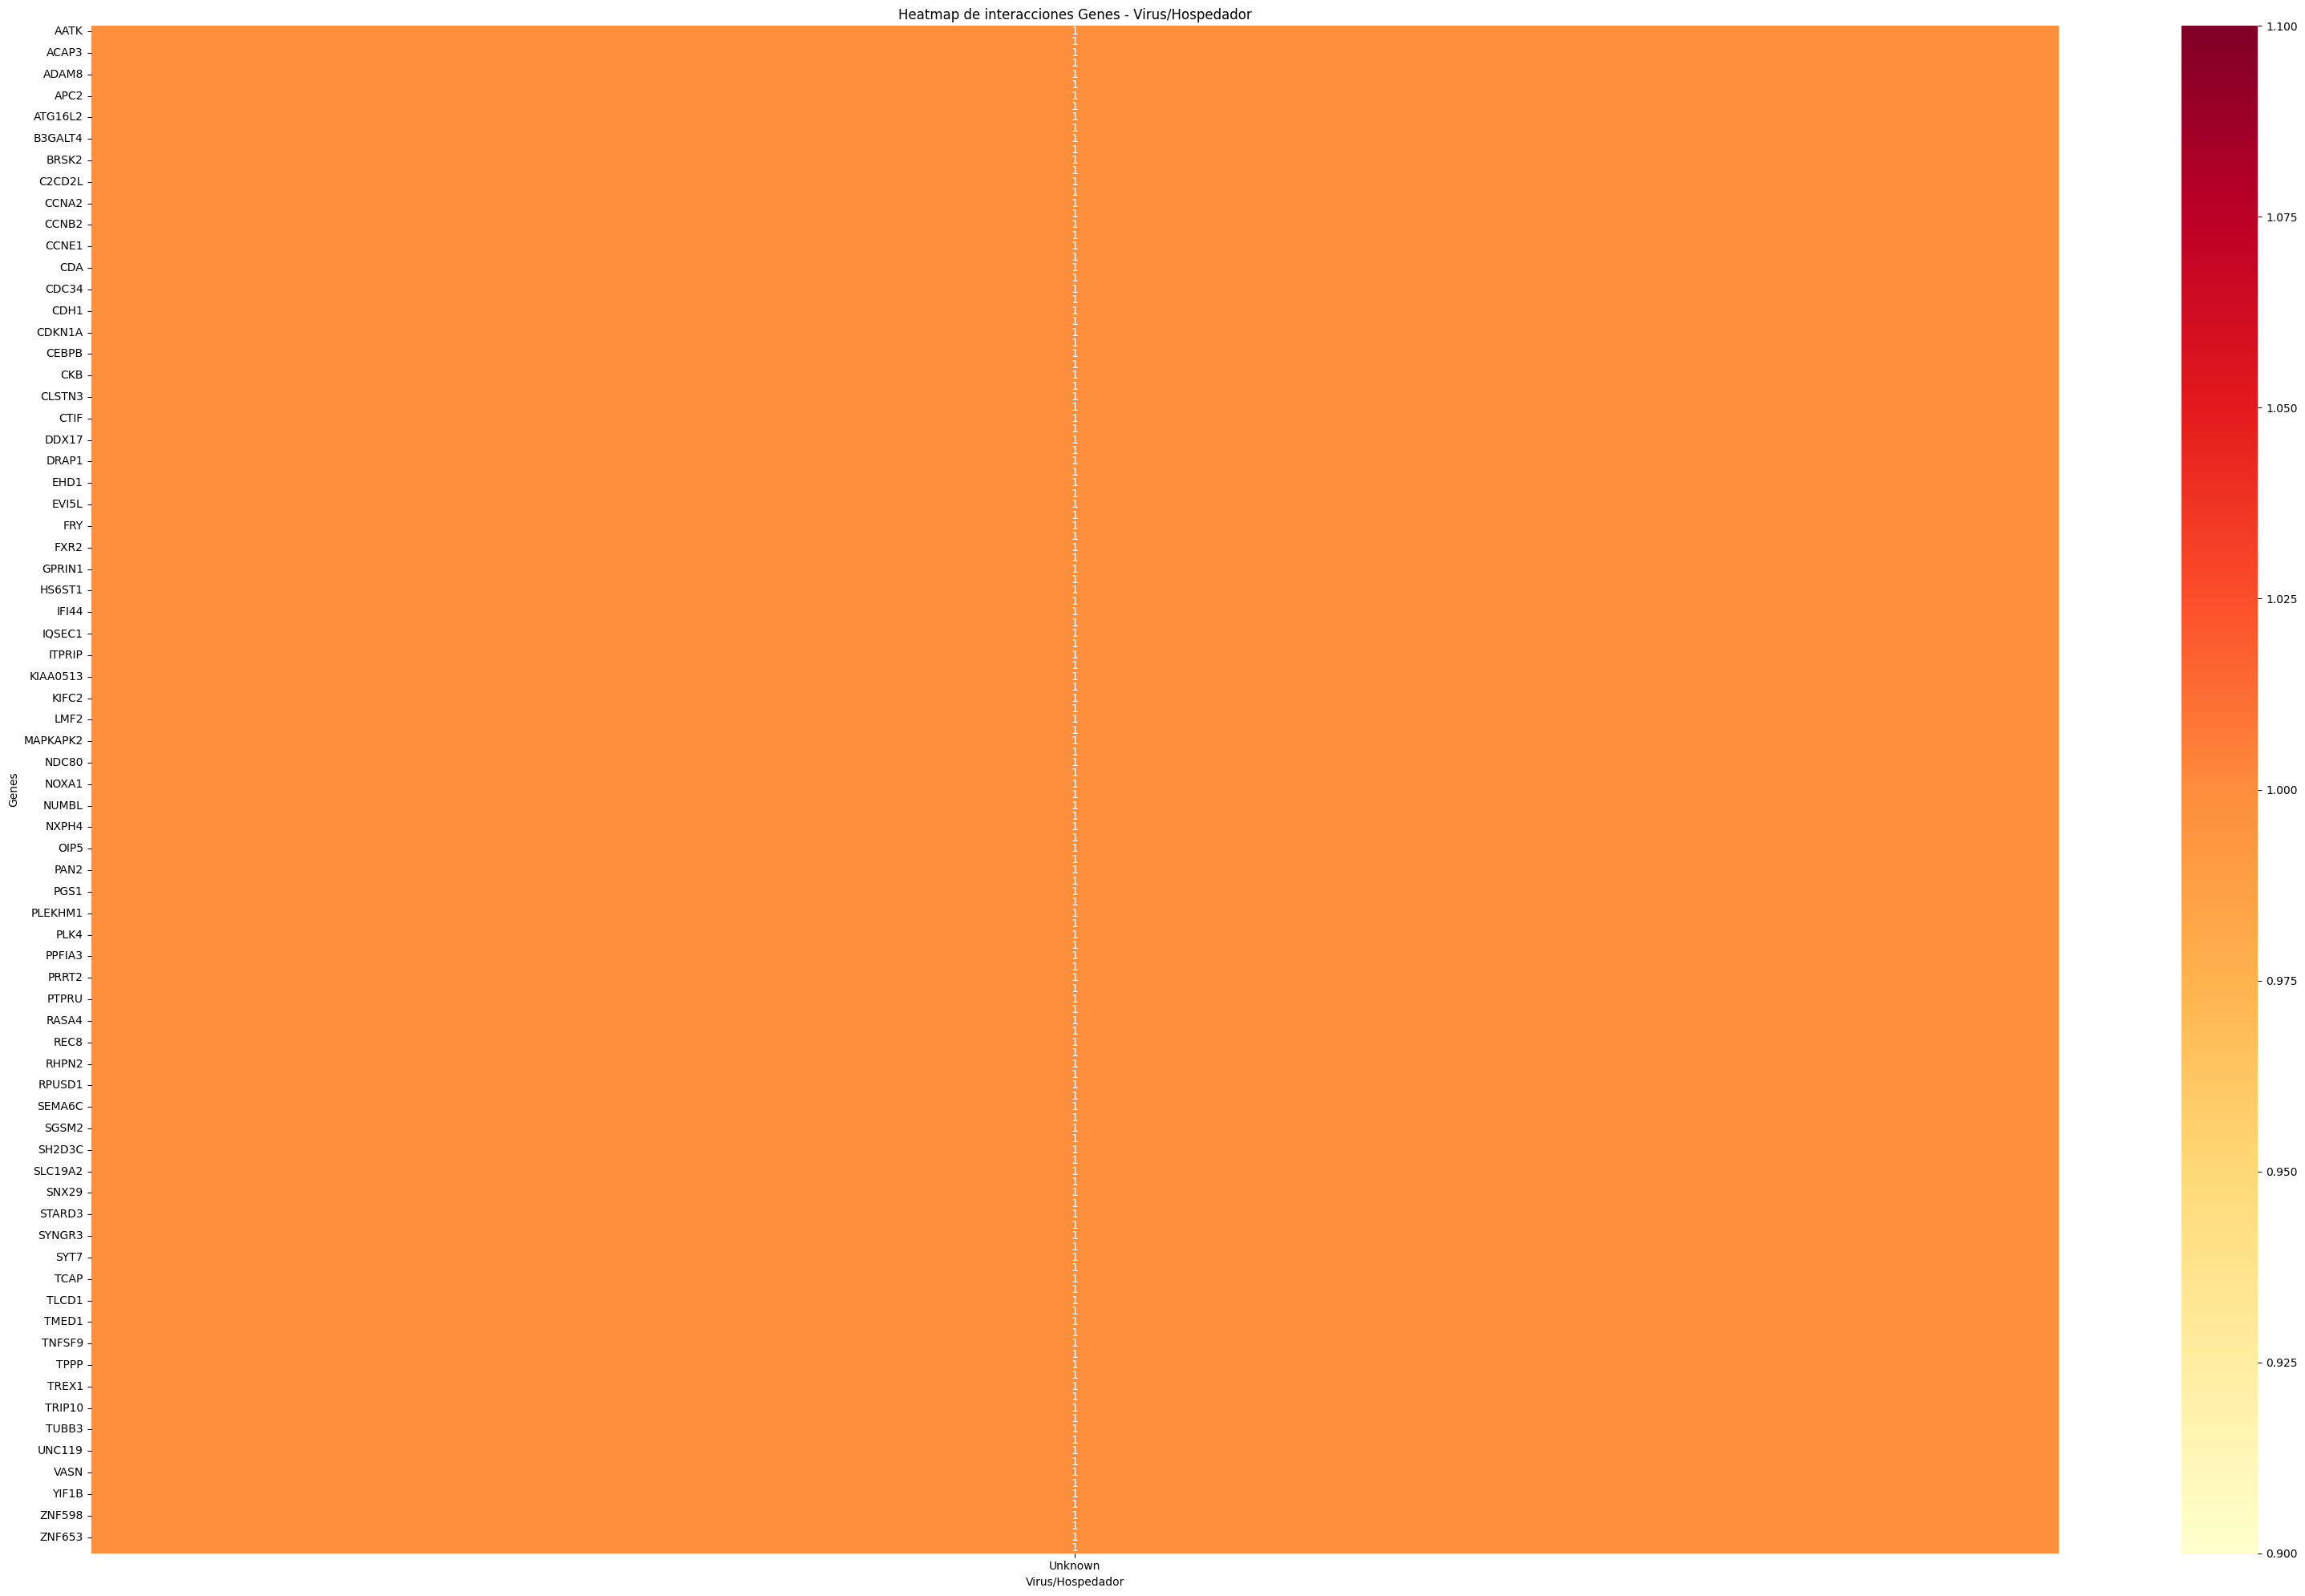

In [18]:
# Procesar las columnas de genes y términos de virus/hospedador para manejar múltiples valores
def process_column(column):
    terms = column.split(';')
    return [term.strip() for term in terms]

# Crear una copia del DataFrame y procesar las columnas relevantes
interaction_df = df[['Genes', 'Virus_Host_Term']].copy()

# Rellenar valores nulos con 'Unknown' y separar los términos
interaction_df['Genes'] = interaction_df['Genes'].fillna('Unknown')
interaction_df['Virus_Host_Term'] = interaction_df['Virus_Host_Term'].fillna('Unknown').apply(process_column)

# Expandir el DataFrame para tener una fila por cada combinación de genes y términos de virus/hospedador
interaction_df = interaction_df.explode('Genes').explode('Virus_Host_Term')

# Crear la matriz de interacciones entre Genes y Virus_Host_Term
interaction_matrix = pd.crosstab(interaction_df['Genes'], interaction_df['Virus_Host_Term'])

# Generar el heatmap
plt.figure(figsize=(32, 20))
sns.heatmap(interaction_matrix, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Heatmap de interacciones Genes - Virus/Hospedador')
plt.xlabel('Virus/Hospedador')
plt.ylabel('Genes')
plt.tight_layout()
plt.savefig('gene_virus_host_heatmap.png')
print("Heatmap guardado como 'gene_virus_host_heatmap.png'")


In [19]:
def process_column(column):
    if pd.isna(column):
        return []  # Manejo de valores NaN
    return [item.strip() for item in column.split(';')]

def filter_top_interactions(df, top_n=50):
    df_expanded = df.copy()
    df_expanded['Virus_Host_Term'] = df_expanded['Virus_Host_Term'].apply(process_column)
    df_expanded['Virus_Host_Pvalue_Adjusted'] = df_expanded['Virus_Host_Pvalue_Adjusted'].apply(lambda x: [float(p) if p.strip() else float('nan') for p in process_column(x)])
    
    df_expanded = df_expanded.explode('Genes')
    df_expanded = df_expanded.explode('Virus_Host_Term')
    df_expanded = df_expanded.explode('Virus_Host_Pvalue_Adjusted')
    
    df_expanded = df_expanded.dropna(subset=['Virus_Host_Pvalue_Adjusted'])  # Eliminar filas con Pvalue NaN
    df_expanded['Virus_Host_Pvalue_Adjusted'] = df_expanded['Virus_Host_Pvalue_Adjusted'].astype(float)  # Convertir a float
    
    df_filtered = df_expanded.sort_values(by='Virus_Host_Pvalue_Adjusted').groupby(['Genes', 'Virus_Host_Term']).first().reset_index()
    df_filtered = df_filtered.nsmallest(top_n, 'Virus_Host_Pvalue_Adjusted')
    
    return df_filtered

# Aplicar el filtro para obtener las mejores 50 interacciones
interaction_df = df[['Genes', 'Virus_Host_Term', 'Virus_Host_Pvalue_Adjusted']].copy()
filtered_df = filter_top_interactions(interaction_df, top_n=50)

# Verificar si filtered_df está vacío
if filtered_df.empty:
    print("El DataFrame filtrado está vacío. No se puede generar el heatmap.")
else:
    # Crear la matriz de interacciones entre Genes y Virus_Host_Term
    interaction_matrix = pd.crosstab(filtered_df['Genes'], filtered_df['Virus_Host_Term'])
    
    # Generar el heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(interaction_matrix, annot=True, cmap='YlOrRd', fmt='d')
    plt.title('Heatmap de las 50 mejores interacciones Genes - Virus/Hospedador (basado en Pvalue_Adjusted)')
    plt.xlabel('Virus/Hospedador')
    plt.ylabel('Genes')
    plt.tight_layout()
    plt.savefig('top50_gene_virus_host_heatmap.png')
    print("Heatmap guardado como 'top50_gene_virus_host_heatmap.png'")

El DataFrame filtrado está vacío. No se puede generar el heatmap.


C:\Users\3060\AppData\Local\Temp\ipykernel_24444\2565225139.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=filtered_df, x='Genes', y='Virus_Host_Term', size='Virus_Host_Pvalue_Adjusted', hue='Virus_Host_Pvalue_Adjusted', palette='viridis', sizes=(20, 200))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Scatter plot guardado como 'top50_gene_virus_host_scatterplot.png'


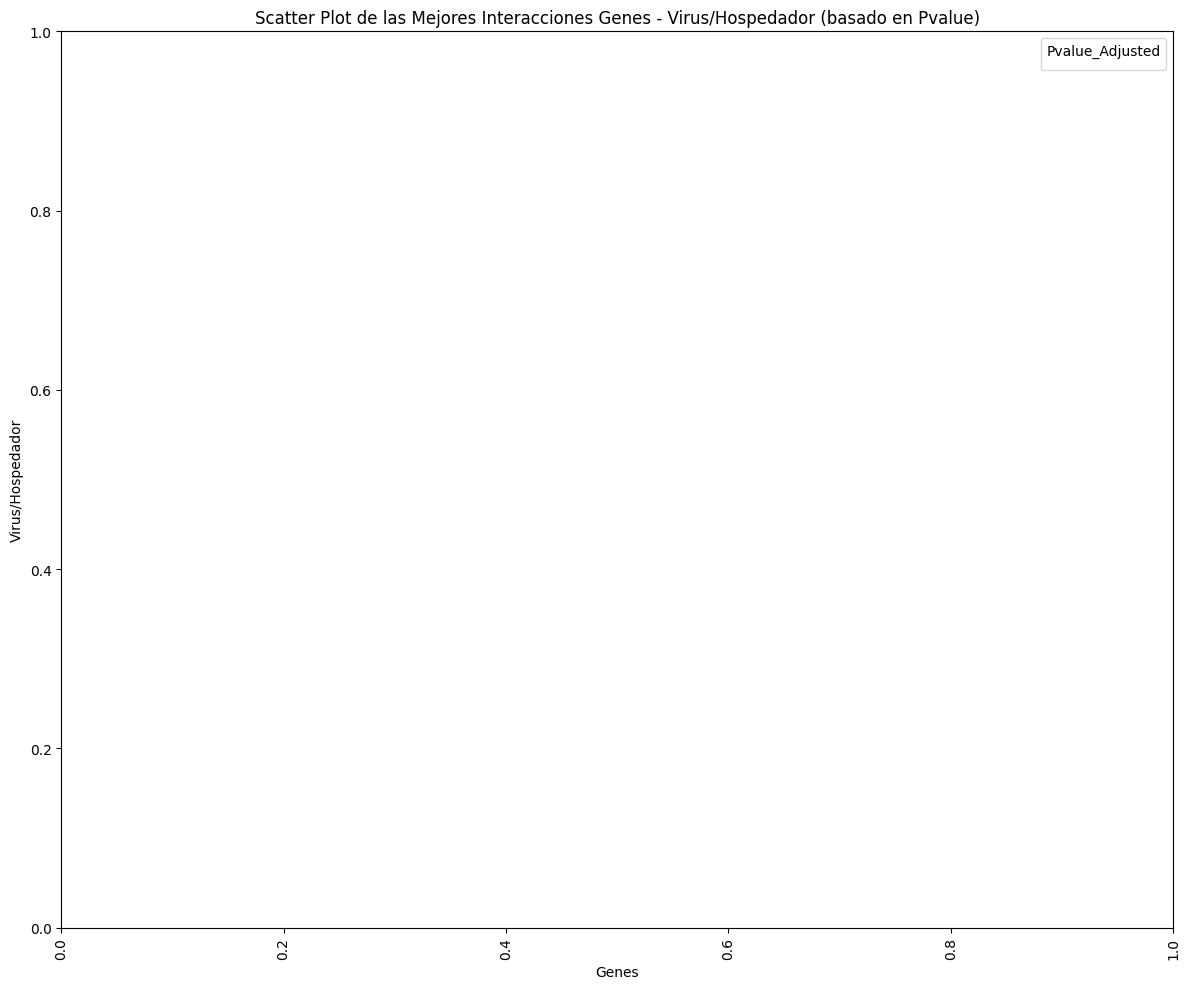

In [20]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=filtered_df, x='Genes', y='Virus_Host_Term', size='Virus_Host_Pvalue_Adjusted', hue='Virus_Host_Pvalue_Adjusted', palette='viridis', sizes=(20, 200))
plt.title('Scatter Plot de las Mejores Interacciones Genes - Virus/Hospedador (basado en Pvalue)')
plt.xlabel('Genes')
plt.ylabel('Virus/Hospedador')
plt.legend(title='Pvalue_Adjusted')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('top50_gene_virus_host_scatterplot.png')
print("Scatter plot guardado como 'top50_gene_virus_host_scatterplot.png'")


Bar plot guardado como 'virus_host_interaction_counts.png'


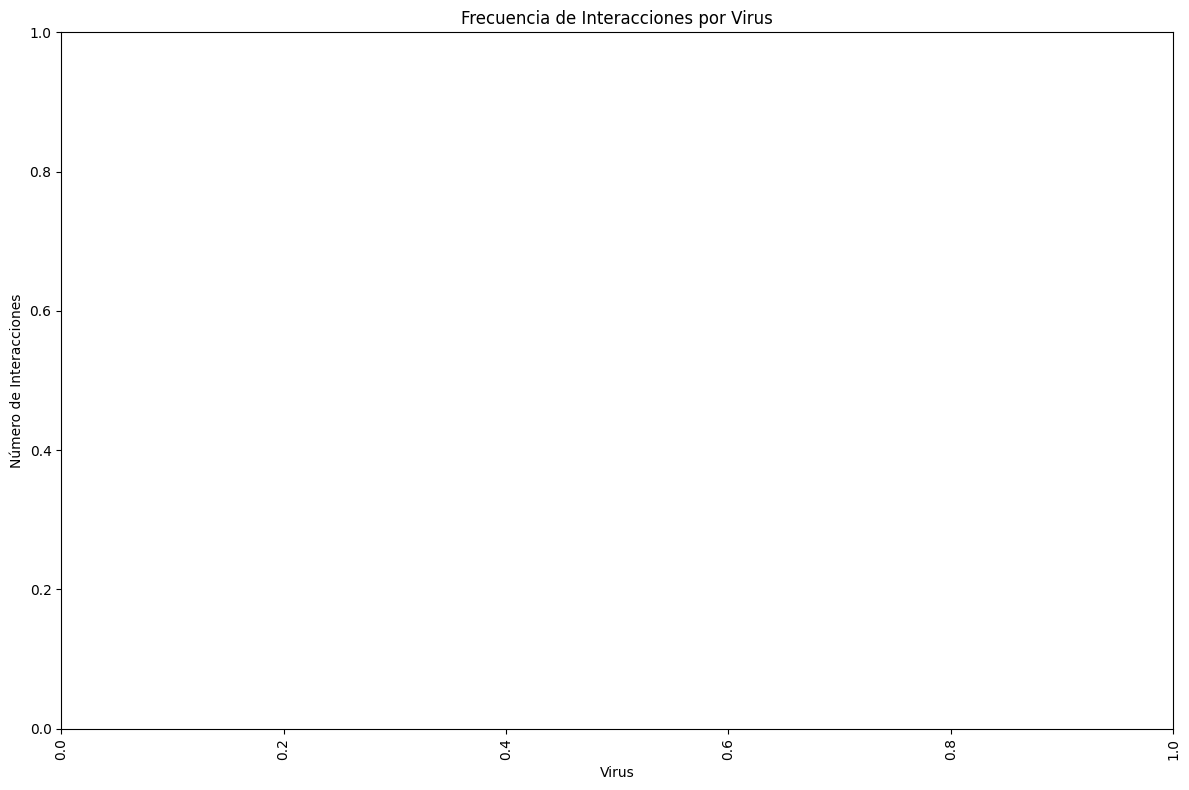

In [21]:

# Contar las interacciones por Virus_Host_Term
interaction_counts = filtered_df['Virus_Host_Term'].value_counts().reset_index()
interaction_counts.columns = ['Virus_Host_Term', 'Count']

plt.figure(figsize=(12, 8))
sns.barplot(data=interaction_counts, x='Virus_Host_Term', y='Count', palette='viridis')
plt.title('Frecuencia de Interacciones por Virus')
plt.xlabel('Virus')
plt.ylabel('Número de Interacciones')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('virus_host_interaction_counts.png')
print("Bar plot guardado como 'virus_host_interaction_counts.png'")


Obtener los archivos de nodos y aristas para crear la red en Cytoscape

In [23]:

# Cargar el archivo CSV
file_path = 'Integracion_con_patógenos_y_enfermedades_Propionibacterium_F_Padj_menor_0.05.csv'
data = pd.read_csv(file_path)

# Crear listas para nodos y aristas
nodos = set()
aristas = []

# Iterar sobre cada fila del DataFrame
for index, row in data.iterrows():
    gene = row['Genes']
    nodos.add((gene, 'Gene'))  # Agregar el gen como nodo

    # Procesar las columnas de enfermedades
    for term, pvalue_column in zip(['DisGeNET_Term', 'GeDiPNet_Term', 'Orphanet_Term'],
                                   ['DisGeNET_Pvalue_Adjusted', 'GeDiPNet_Pvalue_Adjusted', 'Orphanet_Pvalue_Adjusted']):
        if pd.notna(row[term]):  # Verificar que no sea NaN
            enfermedades = row[term].split(';')  # Separar por punto y coma
            pvalues = str(row[pvalue_column]).split(';')  # Separar los valores P correspondientes
            for enfermedad, pvalue in zip(enfermedades, pvalues):
                if float(pvalue) < 0.05:  # Verificar que el valor P ajustado sea menor a 0.05
                    enfermedad_str = enfermedad.strip().replace(",", "")  # Eliminar comas
                    aristas.append((gene, enfermedad_str, float(pvalue)))  # Crear arista con pvalue
                    nodos.add((enfermedad_str, 'Disease'))  # Agregar enfermedad como nodo

    # Procesar las columnas de patógenos
    if pd.notna(row['Virus_Host_Term']):  # Verificar que no sea NaN
        patogenos = row['Virus_Host_Term'].split(';')  # Separar por punto y coma
        pvalues = str(row['Virus_Host_Pvalue_Adjusted']).split(';')  # Separar los valores P correspondientes
        for patogeno, pvalue in zip(patogenos, pvalues):
            if float(pvalue) < 0.05:  # Verificar que el valor P ajustado sea menor a 0.05
                patogeno_str = patogeno.strip().replace(",", "")  # Eliminar comas
                aristas.append((gene, patogeno_str, float(pvalue)))  # Crear arista con pvalue
                nodos.add((patogeno_str, 'Pathogen'))  # Agregar patógeno como nodo

# Crear DataFrame de nodos
nodos_df = pd.DataFrame(list(nodos), columns=['Id', 'Type'])

# Guardar el archivo de nodos
nodos_df.to_csv('nodos.csv', index=False)

# Crear DataFrame de aristas
aristas_df = pd.DataFrame(aristas, columns=['Source', 'Target', 'Pvalue_Adjusted'])

# Eliminar duplicados en aristas
aristas_df = aristas_df.drop_duplicates()

# Guardar el archivo de aristas
aristas_df.to_csv('aristas.csv', index=False)
